In [132]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import IPython.display
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [133]:
files = "./data/merged.csv"

# accleration file
file_accel = "./data/accel-merge.csv"

raw_dataset_accel = pd.read_csv(file_accel, sep=",", skipinitialspace=True)
dataset_accel =raw_dataset_accel.copy()
dataset_no_speed = dataset_accel
dataset_no_speed.pop('Vehicle speed (MPH)')

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()
dataset_accel.columns = dataset_accel.columns.str.lstrip()

In [ ]:
# TODO:
# look at speed vs time

file_no_merge = ["./data/{}-Cleaned.csv".format(i) for i in range(1, 7)]

def plot_speed_time(files):
    raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
    dataset = raw_dataset.copy()
    
    time = dataset.pop("Time (sec)")
    time.tail()
    speed = dataset.pop("Vehicle speed (MPH)")
    
   
    plt.xlabel("Time (sec)")
    plt.ylabel("Speed (MPH)")
    plt.plot(time, speed)
    plt.show()
    
for file in file_no_merge:
    plot_speed_time(file)

In [47]:
# Global parameters
max_num = 45
seed = 9
numEpochs = 250
cap_dataset = False # for testing purposes

In [136]:
#To-do: consider experimenting what happens when you remove it.
#if the maxNum = 45, there are ___1788___ obs whose MPG > 45

#a function that rounds down any value above 45 to 45.
#39 is the avg highway IFE. we then choose the number 45.
#see our doc/write up for more info?

def set_max_ife(dataset, max_num, wanted):
    #    count = 0
    if not wanted: return dataset
    copy = dataset.copy()
    for i in range(len(dataset.index)):
        if dataset.iloc[i, len(dataset.columns) - 1] > max_Num:
#            count += 1
            copy.iloc[i, len(dataset.columns) - 1] = max_Num
#    print(count)
    return copy
maxed_dataset = set_max_ife(dataset_accel, max_num, False)
maxed_dataset.sample(frac=1).reset_index(drop=True)

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Acceleration (mph/s),Fuel rate (gal/hr),Instant fuel economy (MPG)
0,10.980390,10.980390,64.4,29.8254,13.72549,885.9030,190.4,1218.25,77.64706,468.4719,1.000003,77.0,5.610719,3.90625,0.170667,-0.605034,0.113847,163.737700
1,85.882350,55.686280,118.4,29.8254,99.60784,4429.5150,203.0,2448.75,78.03922,2223.4280,0.991402,118.4,28.348900,12.50000,5.080320,4.065682,3.396233,6.403563
2,10.980390,11.372550,62.6,29.8254,13.33333,885.9030,181.4,1204.50,83.92157,587.4028,1.000003,68.0,5.906020,8.59375,0.227556,3.530521,0.151125,135.683700
3,23.137250,12.549020,64.4,29.8254,39.21569,1101.4730,186.8,626.25,78.03922,533.7389,0.995764,75.2,14.174450,3.90625,0.374409,0.000000,0.249690,9.954294
4,91.372550,60.392160,62.6,29.8254,99.60784,4429.5150,185.0,2744.25,78.03922,2153.8100,0.990274,66.2,28.644200,12.50000,5.425623,4.779780,3.634994,6.153893
5,57.647060,27.843140,59.0,29.5301,65.49020,2840.7960,179.6,1620.00,60.39216,1327.0950,0.993019,62.6,26.577090,0.78125,2.353617,0.521284,1.571819,29.648990
6,90.980390,63.921570,62.6,29.8254,99.21568,4429.5150,186.8,2487.75,67.84314,2198.7720,0.990671,64.4,28.939500,10.93750,4.615947,1.049611,3.093679,16.068150
7,22.352940,12.156860,118.4,29.8254,43.52941,1063.0840,195.8,557.25,81.17647,533.7389,1.010343,120.2,14.174450,1.56250,0.336042,0.000000,0.220890,0.000000
8,23.529410,12.156860,64.4,29.8254,39.60784,1107.3790,195.8,621.75,70.98039,533.7389,0.995733,80.6,14.174450,3.90625,0.355887,-0.755007,0.237338,7.854271
9,22.745100,11.764710,87.8,29.8254,43.52941,1080.8020,203.0,557.00,67.84314,519.2351,0.995246,107.6,14.765050,3.90625,0.272538,0.000000,0.181864,0.000000


In [17]:
#Plotting a histograph to see distribution of Vehicle speed (MPH) 
#sns.distplot(maxedDataSet['Vehicle speed (MPH)']);

In [ ]:
set35 = np.full(4859, 35)
set35
plt.plot(maxed_dataset['Vehicle speed (MPH)'], color='g')
plt.plot(set35, color='orange')
plt.xlabel('Observation Number #')
plt.ylabel('Vehicle Speed (MPH)')
plt.title('Plot of Vehicle Speed')
plt.figure(figsize=(36, 32))
plt.show()

In [19]:
#dataset.iloc[:, len(dataset.columns) - 3] #yes - way to access speed

#a function that counts how many data points are that whose speed is more than 35 
#(meaning that the car is in the highway)

def find_highway_speed(dataset, max_num):
    count = 0
    copy = dataset.copy()
    array_speed = []
    for i in range(len(dataset.index)):
        if dataset.iloc[i, len(dataset.columns) - 3] > max_num:
            count += 1
            array_speed.append(i)
    print(count)
    return array_speed

list_highway_speed = find_highway_speed(maxed_dataset, 35)

#for i in range(1,len(list_highway_speed))):
#    print(list_highway_speed[i])

1536


In [203]:
#print(list_highway_speed)
#for i in range(1,len(list_highway_speed))):
#    highway_speed_dataset = maxed_dataset[list_highway_speed[i]]


In [137]:
%%time 
#set seed here!
# dataset_accel = dataset_accel.sample(frac=1).reset_index(drop=True)
# dataset_no_speed = dataset_no_speed.sample(frac=1).reset_index(drop=True)

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
# dataset = dataset.sample(frac=1).reset_index(drop=True)
train, validate, test = train_validate_test_split(maxed_dataset)

train_labels = train.pop("Instant fuel economy (MPG)")
validate_labels = validate.pop("Instant fuel economy (MPG)")
test_labels = test.pop("Instant fuel economy (MPG)")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.98 ms


In [117]:
#train.dtypes

In [135]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))

# train_stats is a pandas data frame type
train_stats = train.describe(include = 'all')
train_stats

train_stats['Vehicle speed (MPH)']

count    2916.000000
mean       26.669737
std        22.193794
min         0.000000
25%         6.213712
50%        24.854850
75%        39.146390
max        75.185910
Name: Vehicle speed (MPH), dtype: float64

In [119]:
train_stats['Vehicle speed (MPH)'][1] #mean

26.764988836831275

In [138]:
#we have to normalize test and validation data set by using the mean and sd from training data set

# Even if we make our own, the values are similar but not exact. mine vs their mean and var
# issue: i am copying the set, find better way to not copy huge set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

In [265]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
#this method normalizes it according to the mean and sd from each set instead of 
#normalizaing from training set only# scaler = StandardScaler()

# a bit buggy
# normed_train = scaler.fit_transform(train)
# normed_validate = scaler.fit_transform(validate)
# normed_test = scaler.fit_transform(test)



In [139]:
# build models with different number of activation layers and number of nodes to explore
# which one has lowest testing error
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_B():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_C():
  model = keras.Sequential([
    layers.Dense(15, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(10, activation=tf.nn.relu),
    layers.Dense(5, activation=tf.nn.relu),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model



In [140]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()
model_C = build_model_C()
model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 5)                 90        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 6         
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 20)                360       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 21        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)    

In [25]:
%%time
# Also buggy: 

#change batch size? try early stop - The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))

Instructions for updating:
Use tf.cast instead.
CPU times: user 45.1 s, sys: 20.8 s, total: 1min 5s
Wall time: 27.9 s


In [141]:
%%time

# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_B = model_B.fit(normed_train, train_labels, epochs=250, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 4230 samples, validate on 1410 samples
Epoch 1/250
 - 0s - loss: 9235.0122 - mean_absolute_error: 58.1467 - mean_squared_error: 9235.0127 - val_loss: 10843.2187 - val_mean_absolute_error: 63.6106 - val_mean_squared_error: 10843.2188
Epoch 2/250
 - 0s - loss: 8741.2304 - mean_absolute_error: 56.2894 - mean_squared_error: 8741.2285 - val_loss: 10190.5239 - val_mean_absolute_error: 61.3307 - val_mean_squared_error: 10190.5244
Epoch 3/250
 - 0s - loss: 8053.2105 - mean_absolute_error: 53.7416 - mean_squared_error: 8053.2104 - val_loss: 9319.7080 - val_mean_absolute_error: 58.3238 - val_mean_squared_error: 9319.7080
Epoch 4/250
 - 0s - loss: 7234.9636 - mean_absolute_error: 50.6033 - mean_squared_error: 7234.9629 - val_loss: 8321.5396 - val_mean_absolute_error: 54.7373 - val_mean_squared_error: 8321.5410
Epoch 5/250
 - 0s - loss: 6343.7208 - mean_absolute_error: 46.9443 - mean_squared_error: 6343.7192 - val_loss: 7237.6606 - val_mean_absolute_error: 50.4305 - val_mean_squared_error

Epoch 44/250
 - 0s - loss: 2229.6161 - mean_absolute_error: 23.7749 - mean_squared_error: 2229.6157 - val_loss: 2756.7285 - val_mean_absolute_error: 26.4356 - val_mean_squared_error: 2756.7285
Epoch 45/250
 - 0s - loss: 2217.0973 - mean_absolute_error: 23.6324 - mean_squared_error: 2217.0974 - val_loss: 2759.3685 - val_mean_absolute_error: 26.4963 - val_mean_squared_error: 2759.3687
Epoch 46/250
 - 0s - loss: 2203.8230 - mean_absolute_error: 23.5342 - mean_squared_error: 2203.8230 - val_loss: 2743.9573 - val_mean_absolute_error: 26.4336 - val_mean_squared_error: 2743.9570
Epoch 47/250
 - 0s - loss: 2189.2001 - mean_absolute_error: 23.4423 - mean_squared_error: 2189.2004 - val_loss: 2693.4871 - val_mean_absolute_error: 26.0702 - val_mean_squared_error: 2693.4871
Epoch 48/250
 - 0s - loss: 2178.3106 - mean_absolute_error: 23.4505 - mean_squared_error: 2178.3101 - val_loss: 2696.9188 - val_mean_absolute_error: 26.1433 - val_mean_squared_error: 2696.9189
Epoch 49/250
 - 0s - loss: 2164.126

Epoch 87/250
 - 0s - loss: 1908.2303 - mean_absolute_error: 21.3700 - mean_squared_error: 1908.2306 - val_loss: 2482.6876 - val_mean_absolute_error: 24.6178 - val_mean_squared_error: 2482.6877
Epoch 88/250
 - 0s - loss: 1903.7183 - mean_absolute_error: 21.3823 - mean_squared_error: 1903.7184 - val_loss: 2479.6386 - val_mean_absolute_error: 24.5677 - val_mean_squared_error: 2479.6389
Epoch 89/250
 - 0s - loss: 1899.0186 - mean_absolute_error: 21.3210 - mean_squared_error: 1899.0193 - val_loss: 2499.9929 - val_mean_absolute_error: 24.7537 - val_mean_squared_error: 2499.9927
Epoch 90/250
 - 0s - loss: 1895.2393 - mean_absolute_error: 21.3664 - mean_squared_error: 1895.2394 - val_loss: 2498.0659 - val_mean_absolute_error: 24.7456 - val_mean_squared_error: 2498.0657
Epoch 91/250
 - 0s - loss: 1891.2777 - mean_absolute_error: 21.2892 - mean_squared_error: 1891.2775 - val_loss: 2476.5233 - val_mean_absolute_error: 24.4864 - val_mean_squared_error: 2476.5237
Epoch 92/250
 - 0s - loss: 1888.477

Epoch 130/250
 - 0s - loss: 1781.3703 - mean_absolute_error: 20.6694 - mean_squared_error: 1781.3708 - val_loss: 2497.8529 - val_mean_absolute_error: 25.3982 - val_mean_squared_error: 2497.8533
Epoch 131/250
 - 0s - loss: 1781.0914 - mean_absolute_error: 20.5558 - mean_squared_error: 1781.0916 - val_loss: 2466.4041 - val_mean_absolute_error: 25.0636 - val_mean_squared_error: 2466.4038
Epoch 132/250
 - 0s - loss: 1779.6427 - mean_absolute_error: 20.5230 - mean_squared_error: 1779.6428 - val_loss: 2457.4501 - val_mean_absolute_error: 25.0082 - val_mean_squared_error: 2457.4502
Epoch 133/250
 - 0s - loss: 1778.0982 - mean_absolute_error: 20.5288 - mean_squared_error: 1778.0983 - val_loss: 2447.2614 - val_mean_absolute_error: 24.9118 - val_mean_squared_error: 2447.2617
Epoch 134/250
 - 0s - loss: 1774.8676 - mean_absolute_error: 20.5094 - mean_squared_error: 1774.8679 - val_loss: 2423.4420 - val_mean_absolute_error: 24.6599 - val_mean_squared_error: 2423.4424
Epoch 135/250
 - 0s - loss: 17

Epoch 173/250
 - 0s - loss: 1706.1107 - mean_absolute_error: 20.0518 - mean_squared_error: 1706.1107 - val_loss: 2411.2943 - val_mean_absolute_error: 24.9447 - val_mean_squared_error: 2411.2944
Epoch 174/250
 - 0s - loss: 1704.1219 - mean_absolute_error: 20.1125 - mean_squared_error: 1704.1216 - val_loss: 2424.5538 - val_mean_absolute_error: 25.0644 - val_mean_squared_error: 2424.5540
Epoch 175/250
 - 0s - loss: 1702.8447 - mean_absolute_error: 20.1024 - mean_squared_error: 1702.8446 - val_loss: 2422.3717 - val_mean_absolute_error: 25.0463 - val_mean_squared_error: 2422.3718
Epoch 176/250
 - 0s - loss: 1701.6912 - mean_absolute_error: 20.0668 - mean_squared_error: 1701.6913 - val_loss: 2423.3198 - val_mean_absolute_error: 25.0995 - val_mean_squared_error: 2423.3196
Epoch 177/250
 - 0s - loss: 1699.1740 - mean_absolute_error: 20.0947 - mean_squared_error: 1699.1740 - val_loss: 2398.4615 - val_mean_absolute_error: 24.7766 - val_mean_squared_error: 2398.4614
Epoch 178/250
 - 0s - loss: 16

Epoch 216/250
 - 0s - loss: 1640.8216 - mean_absolute_error: 19.7318 - mean_squared_error: 1640.8212 - val_loss: 2387.4337 - val_mean_absolute_error: 25.0731 - val_mean_squared_error: 2387.4338
Epoch 217/250
 - 0s - loss: 1640.4934 - mean_absolute_error: 19.6882 - mean_squared_error: 1640.4934 - val_loss: 2380.9147 - val_mean_absolute_error: 24.9241 - val_mean_squared_error: 2380.9143
Epoch 218/250
 - 0s - loss: 1639.3504 - mean_absolute_error: 19.6472 - mean_squared_error: 1639.3503 - val_loss: 2388.9935 - val_mean_absolute_error: 25.1295 - val_mean_squared_error: 2388.9939
Epoch 219/250
 - 0s - loss: 1637.9382 - mean_absolute_error: 19.6790 - mean_squared_error: 1637.9381 - val_loss: 2389.4826 - val_mean_absolute_error: 25.1103 - val_mean_squared_error: 2389.4832
Epoch 220/250
 - 0s - loss: 1637.1542 - mean_absolute_error: 19.5840 - mean_squared_error: 1637.1542 - val_loss: 2346.1256 - val_mean_absolute_error: 24.5337 - val_mean_squared_error: 2346.1255
Epoch 221/250
 - 0s - loss: 16

In [142]:
%%time
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_C = model_C.fit(normed_train, train_labels, epochs=250, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 4230 samples, validate on 1410 samples
Epoch 1/250
 - 1s - loss: 9366.3810 - mean_absolute_error: 57.8081 - mean_squared_error: 9366.3838 - val_loss: 10952.9802 - val_mean_absolute_error: 62.6104 - val_mean_squared_error: 10952.9795
Epoch 2/250
 - 0s - loss: 8503.6166 - mean_absolute_error: 53.8920 - mean_squared_error: 8503.6143 - val_loss: 9218.1756 - val_mean_absolute_error: 56.4323 - val_mean_squared_error: 9218.1768
Epoch 3/250
 - 0s - loss: 6294.7695 - mean_absolute_error: 46.2686 - mean_squared_error: 6294.7681 - val_loss: 5950.7924 - val_mean_absolute_error: 45.2292 - val_mean_squared_error: 5950.7915
Epoch 4/250
 - 0s - loss: 4163.2332 - mean_absolute_error: 37.7634 - mean_squared_error: 4163.2319 - val_loss: 4262.4050 - val_mean_absolute_error: 38.2863 - val_mean_squared_error: 4262.4048
Epoch 5/250
 - 0s - loss: 3675.8363 - mean_absolute_error: 35.3419 - mean_squared_error: 3675.8369 - val_loss: 3918.3318 - val_mean_absolute_error: 36.1225 - val_mean_squared_error: 

Epoch 44/250
 - 0s - loss: 1752.3922 - mean_absolute_error: 19.5243 - mean_squared_error: 1752.3920 - val_loss: 2460.0057 - val_mean_absolute_error: 23.6569 - val_mean_squared_error: 2460.0061
Epoch 45/250
 - 0s - loss: 1740.8083 - mean_absolute_error: 19.4535 - mean_squared_error: 1740.8083 - val_loss: 2425.8573 - val_mean_absolute_error: 23.7269 - val_mean_squared_error: 2425.8572
Epoch 46/250
 - 0s - loss: 1734.9300 - mean_absolute_error: 19.4449 - mean_squared_error: 1734.9301 - val_loss: 2483.4433 - val_mean_absolute_error: 23.9903 - val_mean_squared_error: 2483.4436
Epoch 47/250
 - 0s - loss: 1712.6418 - mean_absolute_error: 19.3443 - mean_squared_error: 1712.6420 - val_loss: 2446.0125 - val_mean_absolute_error: 23.9191 - val_mean_squared_error: 2446.0125
Epoch 48/250
 - 0s - loss: 1710.2007 - mean_absolute_error: 19.3606 - mean_squared_error: 1710.2012 - val_loss: 2515.4800 - val_mean_absolute_error: 24.3216 - val_mean_squared_error: 2515.4805
Epoch 49/250
 - 0s - loss: 1707.033

Epoch 87/250
 - 0s - loss: 1433.5841 - mean_absolute_error: 18.1458 - mean_squared_error: 1433.5841 - val_loss: 2318.8013 - val_mean_absolute_error: 23.1538 - val_mean_squared_error: 2318.8008
Epoch 88/250
 - 0s - loss: 1432.4509 - mean_absolute_error: 18.0778 - mean_squared_error: 1432.4509 - val_loss: 2232.6573 - val_mean_absolute_error: 22.6841 - val_mean_squared_error: 2232.6572
Epoch 89/250
 - 0s - loss: 1423.6969 - mean_absolute_error: 18.0855 - mean_squared_error: 1423.6968 - val_loss: 2257.2975 - val_mean_absolute_error: 22.8114 - val_mean_squared_error: 2257.2976
Epoch 90/250
 - 0s - loss: 1415.1206 - mean_absolute_error: 18.0751 - mean_squared_error: 1415.1204 - val_loss: 2256.9963 - val_mean_absolute_error: 22.6357 - val_mean_squared_error: 2256.9966
Epoch 91/250
 - 0s - loss: 1409.7655 - mean_absolute_error: 18.0503 - mean_squared_error: 1409.7656 - val_loss: 2206.5479 - val_mean_absolute_error: 22.4677 - val_mean_squared_error: 2206.5481
Epoch 92/250
 - 0s - loss: 1392.238

Epoch 130/250
 - 0s - loss: 1141.5092 - mean_absolute_error: 16.8697 - mean_squared_error: 1141.5089 - val_loss: 2051.5447 - val_mean_absolute_error: 21.6906 - val_mean_squared_error: 2051.5444
Epoch 131/250
 - 0s - loss: 1135.3742 - mean_absolute_error: 16.7782 - mean_squared_error: 1135.3741 - val_loss: 2032.8191 - val_mean_absolute_error: 21.6856 - val_mean_squared_error: 2032.8193
Epoch 132/250
 - 0s - loss: 1136.1220 - mean_absolute_error: 16.7900 - mean_squared_error: 1136.1219 - val_loss: 1936.4410 - val_mean_absolute_error: 21.6476 - val_mean_squared_error: 1936.4412
Epoch 133/250
 - 0s - loss: 1127.3264 - mean_absolute_error: 16.7605 - mean_squared_error: 1127.3265 - val_loss: 1944.9757 - val_mean_absolute_error: 21.4979 - val_mean_squared_error: 1944.9761
Epoch 134/250
 - 0s - loss: 1122.9062 - mean_absolute_error: 16.7274 - mean_squared_error: 1122.9061 - val_loss: 1897.3550 - val_mean_absolute_error: 21.5149 - val_mean_squared_error: 1897.3546
Epoch 135/250
 - 0s - loss: 11

Epoch 173/250
 - 0s - loss: 919.2519 - mean_absolute_error: 15.7901 - mean_squared_error: 919.2518 - val_loss: 1915.0258 - val_mean_absolute_error: 21.9628 - val_mean_squared_error: 1915.0258
Epoch 174/250
 - 0s - loss: 914.6824 - mean_absolute_error: 15.8041 - mean_squared_error: 914.6824 - val_loss: 2090.9660 - val_mean_absolute_error: 22.7304 - val_mean_squared_error: 2090.9666
Epoch 175/250
 - 0s - loss: 906.8673 - mean_absolute_error: 15.7389 - mean_squared_error: 906.8670 - val_loss: 1956.0937 - val_mean_absolute_error: 22.2592 - val_mean_squared_error: 1956.0936
Epoch 176/250
 - 0s - loss: 902.2017 - mean_absolute_error: 15.7879 - mean_squared_error: 902.2017 - val_loss: 1924.7489 - val_mean_absolute_error: 21.9690 - val_mean_squared_error: 1924.7489
Epoch 177/250
 - 0s - loss: 906.3391 - mean_absolute_error: 15.7347 - mean_squared_error: 906.3390 - val_loss: 2036.8359 - val_mean_absolute_error: 22.5396 - val_mean_squared_error: 2036.8358
Epoch 178/250
 - 0s - loss: 889.8988 - m

Epoch 216/250
 - 0s - loss: 793.2847 - mean_absolute_error: 15.1406 - mean_squared_error: 793.2845 - val_loss: 1882.3658 - val_mean_absolute_error: 22.2465 - val_mean_squared_error: 1882.3657
Epoch 217/250
 - 0s - loss: 784.1412 - mean_absolute_error: 15.1450 - mean_squared_error: 784.1412 - val_loss: 1940.4780 - val_mean_absolute_error: 22.5605 - val_mean_squared_error: 1940.4777
Epoch 218/250
 - 0s - loss: 783.3651 - mean_absolute_error: 15.1248 - mean_squared_error: 783.3654 - val_loss: 2108.0626 - val_mean_absolute_error: 23.5120 - val_mean_squared_error: 2108.0627
Epoch 219/250
 - 0s - loss: 783.5630 - mean_absolute_error: 15.1819 - mean_squared_error: 783.5630 - val_loss: 1868.4666 - val_mean_absolute_error: 22.2561 - val_mean_squared_error: 1868.4663
Epoch 220/250
 - 0s - loss: 781.2874 - mean_absolute_error: 15.1490 - mean_squared_error: 781.2873 - val_loss: 1912.1326 - val_mean_absolute_error: 22.3624 - val_mean_squared_error: 1912.1326
Epoch 221/250
 - 0s - loss: 778.8352 - m

In [143]:
hist_C = pd.DataFrame(history_object_C.history)
hist_C['epoch'] = history_object_C.epoch
hist_C.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
245,728.226874,14.814047,728.227051,1840.683853,22.126455,1840.684204,245
246,713.940418,14.850700,713.940369,1892.750841,22.369173,1892.750732,246
247,725.929724,14.806720,725.929810,1939.168500,22.584255,1939.168457,247
248,724.655807,14.881724,724.655945,1976.100113,22.898146,1976.100220,248
249,730.328434,14.774176,730.328186,2244.274365,24.593019,2244.274170,249


In [144]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.xlim([0,250])
  plt.ylim([0, 8000])
  plt.legend()
  plt.show()

In [ ]:
plot_history(history_object_A)

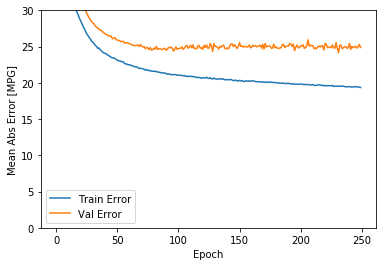

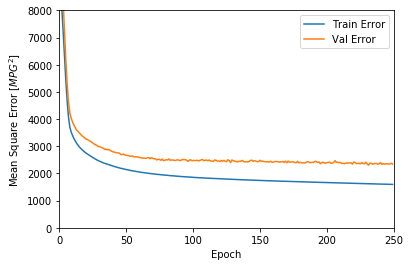

In [145]:
# Increase num epochs? in reference to 2nd graph
# Mean abs error seems to be a better cost function

# For Mean Abs,the variance starts to in|crease after epoch 200, maybe stop there?
# For Mean Square, the variance start to increase after epoch 150, stop here?

# Mean Squared Error seems to be industry standard for regression problems. 
plot_history(history_object_B)

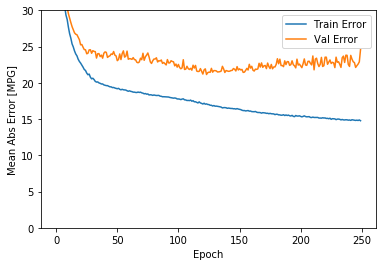

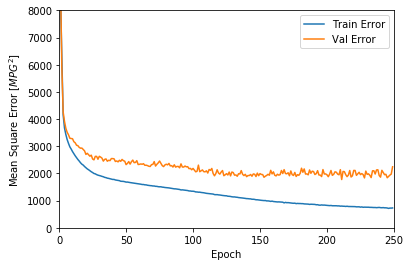

In [146]:
plot_history(history_object_C)

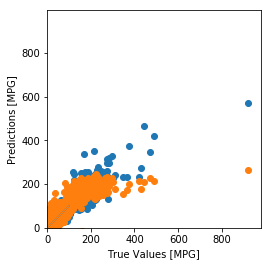

In [147]:
def plot_scatter(test_predictions):
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

test_predictions_C = model_C.predict(normed_test).flatten()
test_predictions_B = model_B.predict(normed_test).flatten()

plot_scatter(test_predictions_C)
plot_scatter(test_predictions_B)



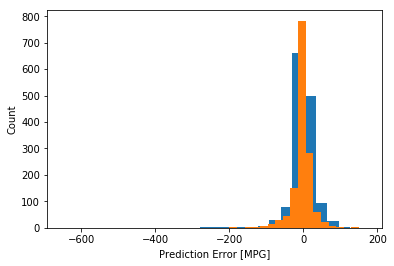

In [148]:
def getHist(test_predictions, test_labels):
    error = test_predictions - test_labels
    plt.xlabel("Prediction Error [MPG]")
    _ = plt.ylabel("Count")
    plt.hist(error, bins = 25)
    return error
errorB = getHist(test_predictions_B, test_labels)
errorC = getHist(test_predictions_C, test_labels)



In [149]:
def calculate_percent_error(test_predictions, test_labels):
    difference = abs(test_predictions - test_labels)
    error = difference / test_labels
    unprocessed_error_percentage = error * 100
    np_error = np.array(unprocessed_error_percentage)
    a = np.ma.masked_invalid(np_error)
    error_percentage = a.sum() / (len(unprocessed_error_percentage) - np.count_nonzero(np.isinf(unprocessed_error_percentage)))
    print(error_percentage)
    return (error_percentage)
    
p_err_B = calculate_percent_error(test_predictions_B, test_labels)
p_err_C = calculate_percent_error(test_predictions_C, test_labels)

# #https://sciencenotes.org/calculate-percent-error/
# difference_B = abs(test_predictions_B - test_labels)
# difference_C = abs(test_predictions_C - test_labels)
# #difference
# error_B = difference_B / test_labels
# error_C - difference_C / test_labels
# #note that when I print unprocessed_error_percentage, it shows inf value. this is from dividing by 0 from the actual 
# #test values that are 0 sometimes. 
# unprocessed_error_percentage_B = error_B * 100
# np_error_B = np.array(unprocessed_error_percentage)
# a = np.ma.masked_invalid(np_error)
# error_percentage = a.sum() / (len(unprocessed_error_percentage) - np.count_nonzero(np.isinf(unprocessed_error_percentage)))
# error_percentage

59.886885243790054
44.96053920368474


In [150]:
def compute_acc(error_percentage):
    accuracy = 100 - error_percentage
    print(accuracy)
    
compute_acc(p_err_B)
compute_acc(p_err_C)

40.113114756209946
55.03946079631526


In [ ]:
# def print_weights()

In [271]:
# Range of how wrong we allow a prediction to be, random number for now. 
# unsure what is considered "good"
# discussion: what is a good epsilon value

# errorVec is y - y_hat, abs value will be taken care of inside here
def accuracy(errorVec, epsilon):
    numExamples = len(errorVec)
    numCorrect = 0
    for error in errorVec:
        if abs(error) <= epsilon:
            numCorrect += 1
    print("Accuracy with epsilon {}:".format(epsilon), (numCorrect / float(numExamples))*100,"%")

In [273]:
# Increased accuracy to 42% after cleaning data and setting maxed IFO
# Epoch is set to 500
epsilon = 1
test_predictions_B = model_B.predict(normed_test).flatten()
test_labels_np = test_labels.values
errorVec = test_predictions_B - test_labels_np
print(max(test_predictions_B))
accuracy(errorVec, epsilon)

368.85986
Accuracy with epsilon 1: 11.522633744855968 %


In [277]:
# implementing linear regression 
# build linear model
# TODO: implement linear regression with predictions capped and without predictions capped
# are we also editting our predictions?
lm = LinearRegression()

# the data was editting so that the max IFO is 45
model = lm.fit(normed_train, train_labels)
predictions = lm.predict(normed_test) # this is a np array, be careful
print(max(predictions))

# expects series
def cap_predictions(predictions, max_num):
    copy = np.copy(predictions)
    for index, val in enumerate(copy):
        if val > max_num:
            copy[index] = max_num
        if val < 0:
            copy[index] = 0
    return copy
capped_predictions = cap_predictions(predictions, max_num)

191.39420928307382


In [275]:
# Linear Regression plot
# lots of weird looking outliers at true values = 0, 45

def plot_scatter(y, y_hat):
    
    plt.figure
    plt.scatter(y, y_hat)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

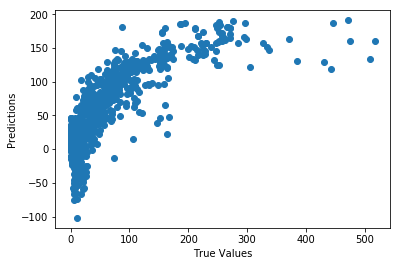

In [276]:
# prediction no cap
plot_scatter(test_labels, predictions)

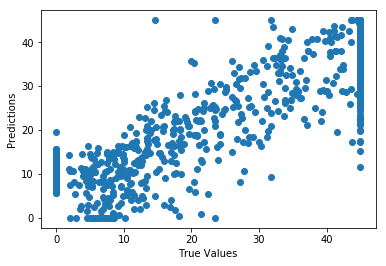

In [243]:
# prediction with cap
plot_scatter(test_labels, capped_predictions)

In [244]:
# Accuracy of linear regression

accuracy(test_labels - predictions, epsilon)
accuracy(test_labels - capped_predictions, epsilon)

Accuracy:  7.510288065843622 %
Accuracy:  18.51851851851852 %
